In [1]:
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import drlqap.experiment as exp
from drlqap.evaltools import load_float_txt
import numpy as np
import json

In [2]:
import importlib
import drlqap.evaltools
importlib.reload(drlqap.evaltools)

<module 'drlqap.evaltools' from '/home/jupyter-tim/ba-tim/src/drlqap/evaltools.py'>

In [3]:
runs_root = Path('../runs')
for c in runs_root.iterdir():
    print(c.name)

dqn_bi_increasing
dqn_dense_ec_eps0_norm_study_2
dqn_dense_ms_ec_eps0_smallrandoms
dqn_mse_eps0_smallrandoms
a2c_ms100x_smallrandoms
reinforce_ms100x_mediumrandoms
mcq_eps0_smallrandoms
dqn_linkedqap_smallrandoms
a2c_ms100x_mediumrandoms_cyclic_wronglr
reinforce_ms100x_smallrandoms
dqn_dense_ms_ec_eps0_mini
dqn_dense_ms_ec_tai35a
a2c_ms100x_increasing
a2c_ms100x_mediumrandoms
a2c_ms100x_mediumrandoms_cyclic
dqn_dense_ec_eps0_norm_study
dqn_dense_ms_ec_eps0_mediumrandoms
reinforce_norm_study
a2c_ms100x_mediumrandoms_stepped
dqn_linkedqap_eps_smallrandoms
dqn_dense_ms_ec_mediumrandoms
a2c_mediumrandoms
dqn_dense_ms_ec_eps0_rni_study


In [4]:
plots_root = Path('../paper/plots/')

In [5]:
def load_experiments(experiment_names, quantity="value"):
    paths = []
    for experiment in experiment_names:
        paths += sorted((runs_root / experiment).iterdir())

    metadatas = [exp.load_metadata(path) for path in paths]
    values = [load_float_txt(path / f"{quantity}.txt") for path in paths]

    metadata = [
        {
            'path': path,
            'seed': meta['seed'],
            'agent_type': meta['agent_type'],
            **meta['agent_arguments'],
        }
        for path, meta in zip(paths, metadatas)
    ]
    meta_df = pd.DataFrame(metadata).fillna(-1) # default values == -1
    meta_index = pd.MultiIndex.from_frame(meta_df)
    return pd.DataFrame(values, index = meta_index)

In [49]:
def aggregate(df, key, window, agg):
        return df.groupby(key).aggregate(agg).transpose().rolling(window).mean()

def generate_variation_plot(df, keys, window, labels=None, blurred_width=8, mean_width=2):
    if type(keys) != list:
        keys = [keys]
    
    mean = aggregate(df, keys, window, 'mean')
    upper = aggregate(df, keys, window, 'max')
    lower = aggregate(df, keys, window, 'min')
    cmap = matplotlib.cm.get_cmap('tab10')
    count = len(mean.columns)
    for i, col in enumerate(mean.columns):
        if labels and col not in labels:
            continue
        color = cmap(i)
        #plt.fill_between(mean[col].index, lower[col], upper[col], alpha=0.1, color=color)
        if len(keys) > 1:
            matching_indices = None
            for i, k in enumerate(keys):
                m = df.index.get_level_values(k) == col[i] 
                matching_indices = matching_indices & m if matching_indices is not None else m
        else:
            matching_indices = (df.index.get_level_values(keys[0]) == col)
        individuals = df[matching_indices].transpose().rolling(window).mean()
        for i in individuals:
            plt.plot(individuals[i], alpha=0.15, linewidth=blurred_width, color=color)
        label = labels[col] if labels else col
        plt.plot(mean[col], label=label, color=color, linewidth=mean_width)
    plt.legend()

# Plots on medium_random_graphs (n=16)

## DQN vs A2C

In [7]:
df = load_experiments(["a2c_ms100x_mediumrandoms", "dqn_dense_ms_ec_eps0_mediumrandoms"])
df = df.query('agent_type != "dqn_dense_ms_ec_eps0" | learning_rate > 1e-5') # Drop bad DQN lr

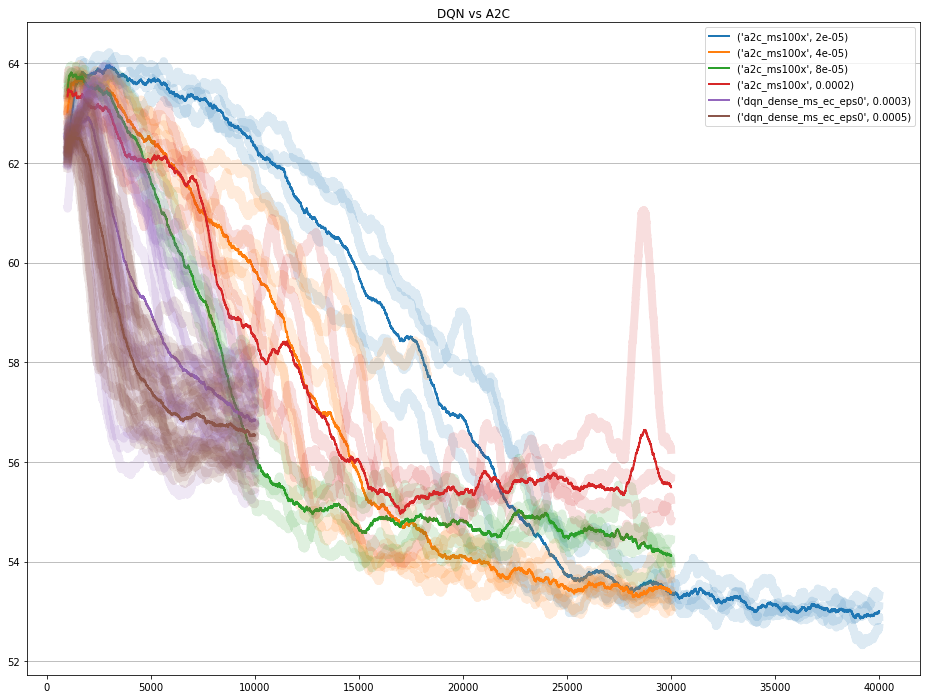

In [8]:
plt.figure(figsize=(16, 12))
plt.title("DQN vs A2C")
plt.grid(axis='y')
generate_variation_plot(df, ['agent_type', 'learning_rate'], 1000)

## A2C hyperparameters

In [9]:
df = load_experiments(["a2c_ms100x_mediumrandoms"])

In [10]:
df

0      \
path                                               seed agent_type learning_rate gnn_depth mlp_depth              
../runs/a2c_ms100x_mediumrandoms/lr2e-4_s1         1    a2c_ms100x 0.00020       -1.0      -1.0       55.767970   
../runs/a2c_ms100x_mediumrandoms/lr2e-4_s2         2    a2c_ms100x 0.00020       -1.0      -1.0       56.686836   
../runs/a2c_ms100x_mediumrandoms/lr2e-4_s3         3    a2c_ms100x 0.00020       -1.0      -1.0       63.027261   
../runs/a2c_ms100x_mediumrandoms/lr2e-4_s4         4    a2c_ms100x 0.00020       -1.0      -1.0       60.797271   
../runs/a2c_ms100x_mediumrandoms/lr2e-5_s1         1    a2c_ms100x 0.00002       -1.0      -1.0       55.040481   
../runs/a2c_ms100x_mediumrandoms/lr2e-5_s2         2    a2c_ms100x 0.00002       -1.0      -1.0       60.005638   
../runs/a2c_ms100x_mediumrandoms/lr2e-5_s3         3    a2c_ms100x 0.00002       -1.0      -1.0       65.511402   
../runs/a2c_ms100x_mediumrandoms/lr2e-5_s4         4    a2c_ms100x 0.00002       -1.0      -1.0       58.249549   
../runs/a2c_ms100x_mediumrandoms/lr4e-5_s1         1    a2c_ms100x 0.00004       -1.0      -1.0       56.110544   
../runs/a2c_ms100x_mediumrandoms/lr4e-5_s1_gd4_md2 1    a2c_ms100x 0.00004        4.0       2.0       56.865747   
../runs/a2c_ms100x_mediumrandoms/lr4e-5_s1_gd4_md4 1    a2c_ms100x 0.00004        4.0       4.0       55.767970   
../runs/a2c_ms100x_mediumrandoms/lr4e-5_s1_gd4_md6 1    a2c_ms100x 0.00004        4.0       6.0       55.767970   
../runs/a2c_ms100x_mediumrandoms/lr4e-5_s2         2    a2c_ms100x 0.00004       -1.0      -1.0       56.686836   
../runs/a2c_ms100x_mediumrandoms/lr4e-5_s3         3    a2c_ms100x 0.00004       -1.0      -1.0       61.103354   
../runs/a2c_ms100x_mediumrandoms/lr4e-5_s4         4    a2c_ms100x 0.00004       -1.0      -1.0       60.992642   
../runs/a2c_ms100x_mediumrandoms/lr8e-5_s1         1    a2c_ms100x 0.00008       -1.0      -1.0       57.026061   
../runs/a2c_ms100x_mediumrandoms/lr8e-5_s2         2    a2c_ms100x 0.00008       -1.0      -1.0       58.168280   
../runs/a2c_ms100x_mediumrandoms/lr8e-5_s3         3    a2c_ms100x 0.00008       -1.0      -1.0       62.611657   
../runs/a2c_ms100x_mediumrandoms/lr8e-5_s4         4    a2c_ms100x 0.00008       -1.0      -1.0       58.283660   

                                                                                                          1      \
path                                               seed agent_type learning_rate gnn_depth mlp_depth              
../runs/a2c_ms100x_mediumrandoms/lr2e-4_s1         1    a2c_ms100x 0.00020       -1.0      -1.0       56.846410   
../runs/a2c_ms100x_mediumrandoms/lr2e-4_s2         2    a2c_ms100x 0.00020       -1.0      -1.0       64.999871   
../runs/a2c_ms100x_mediumrandoms/lr2e-4_s3         3    a2c_ms100x 0.00020       -1.0      -1.0       60.341001   
../runs/a2c_ms100x_mediumrandoms/lr2e-4_s4         4    a2c_ms100x 0.00020       -1.0      -1.0       68.739039   
../runs/a2c_ms100x_mediumrandoms/lr2e-5_s1         1    a2c_ms100x 0.00002       -1.0      -1.0       60.561438   
../runs/a2c_ms100x_mediumrandoms/lr2e-5_s2         2    a2c_ms100x 0.00002       -1.0      -1.0       67.857819   
../runs/a2c_ms100x_mediumrandoms/lr2e-5_s3         3    a2c_ms100x 0.00002       -1.0      -1.0       58.410426   
../runs/a2c_ms100x_mediumrandoms/lr2e-5_s4         4    a2c_ms100x 0.00002       -1.0      -1.0       68.439381   
../runs/a2c_ms100x_mediumrandoms/lr4e-5_s1         1    a2c_ms100x 0.00004       -1.0      -1.0       56.846410   
../runs/a2c_ms100x_mediumrandoms/lr4e-5_s1_gd4_md2 1    a2c_ms100x 0.00004        4.0       2.0       62.869980   
../runs/a2c_ms100x_mediumrandoms/lr4e-5_s1_gd4_md4 1    a2c_ms100x 0.00004        4.0       4.0       56.846410   
../runs/a2c_ms100x_mediumrandoms/lr4e-5_s1_gd4_md6 1    a2c_ms100x 0.00004        4.0       6.0       56.846410   
../runs/a2c_ms100x_mediumrandoms/lr4e-5_s2         2    a2c_ms100x 0.00004      

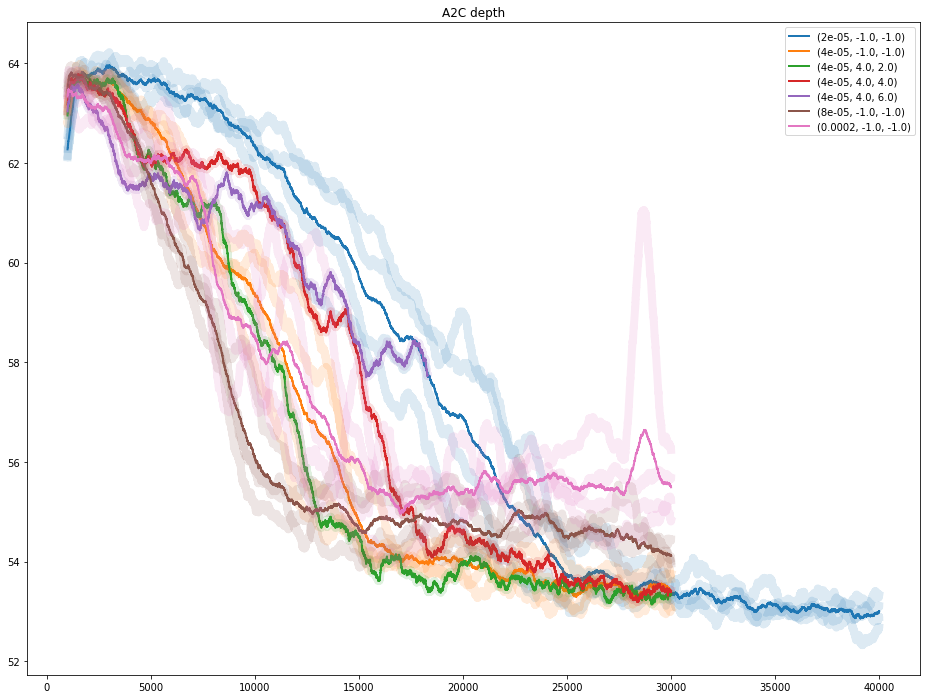

In [11]:
plt.figure(figsize=(16, 12))
plt.title("A2C depth")
generate_variation_plot(df, ['learning_rate', 'gnn_depth', 'mlp_depth'], 1000)

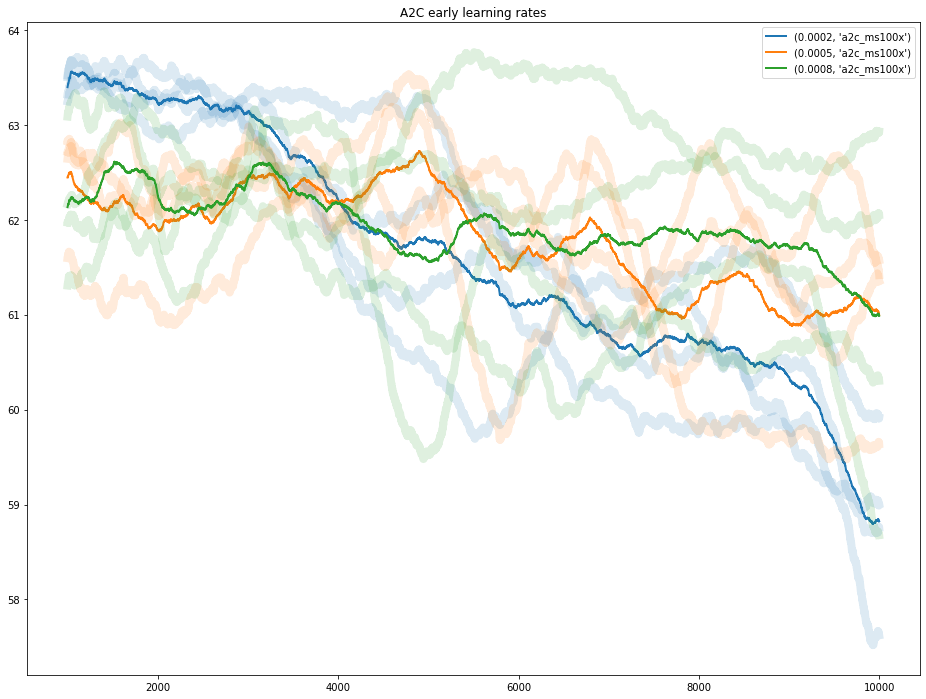

In [12]:
df = load_experiments(["a2c_mediumrandoms"])
plt.figure(figsize=(16, 12))
plt.title("A2C early learning rates")
generate_variation_plot(df.query('agent_type=="a2c_ms100x"'), ['learning_rate', 'agent_type'], 1000)

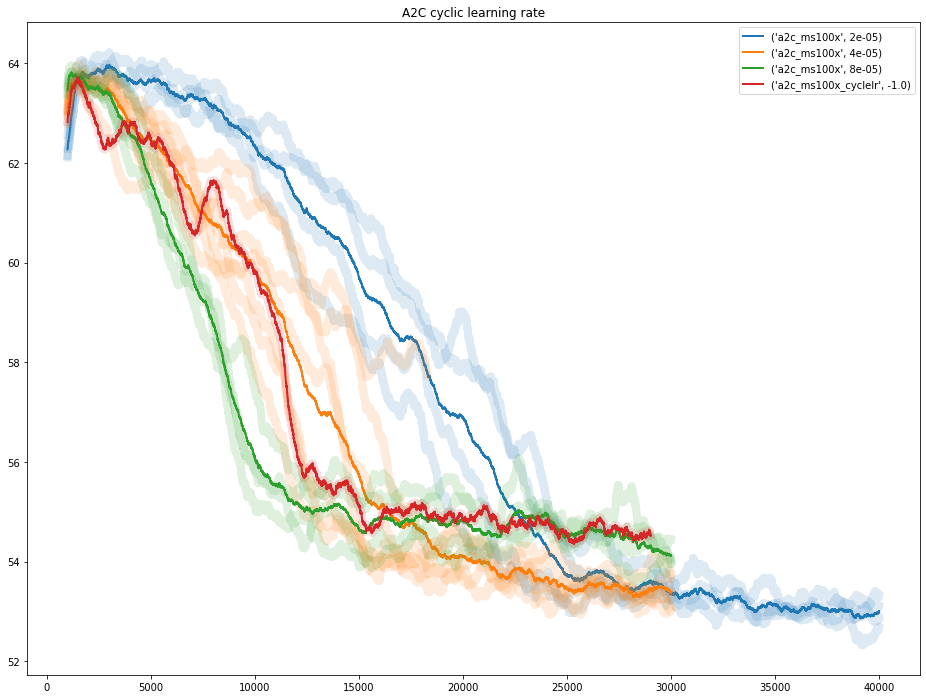

In [13]:
df = load_experiments(["a2c_ms100x_mediumrandoms_cyclic", "a2c_ms100x_mediumrandoms"])
plt.figure(figsize=(16, 12))
plt.title("A2C cyclic learning rate")
generate_variation_plot(df.query("learning_rate <= 8e-5"), ['agent_type', 'learning_rate'], 1000)

In [14]:
with open("../runs/a2c_ms100x_mediumrandoms_stepped/s1/learning_rate.txt") as f:
    lines = f.readlines()
    lrs = [float(l[1:-2]) for l in lines]

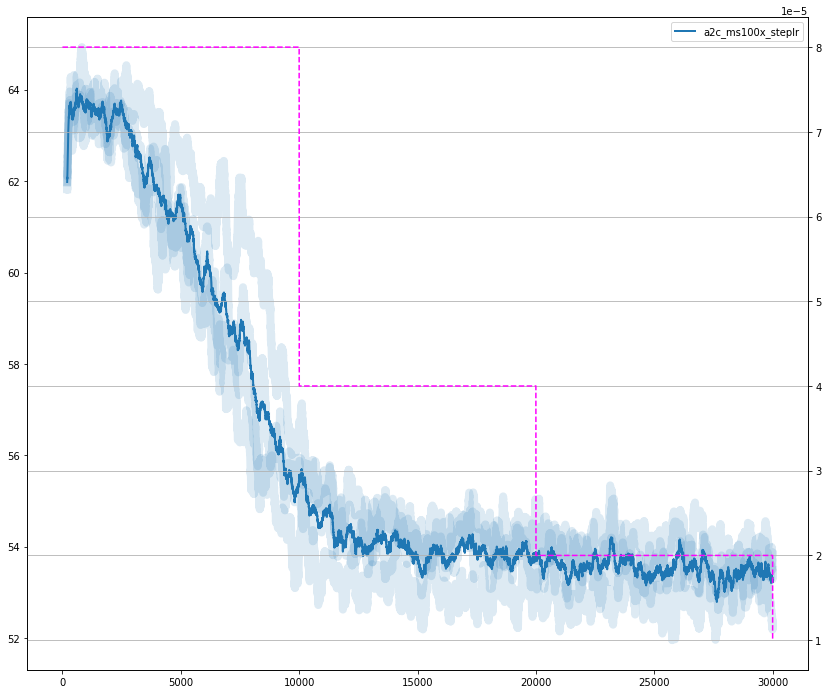

In [15]:
df = load_experiments(["a2c_ms100x_mediumrandoms_stepped"])

plt.figure(figsize=(14,12))
generate_variation_plot(df, ['agent_type'], 200)
ax2 = plt.gca().twinx()
ax2.plot(lrs, linestyle='dashed', color='magenta')
#ax2.semilogy()
plt.grid()

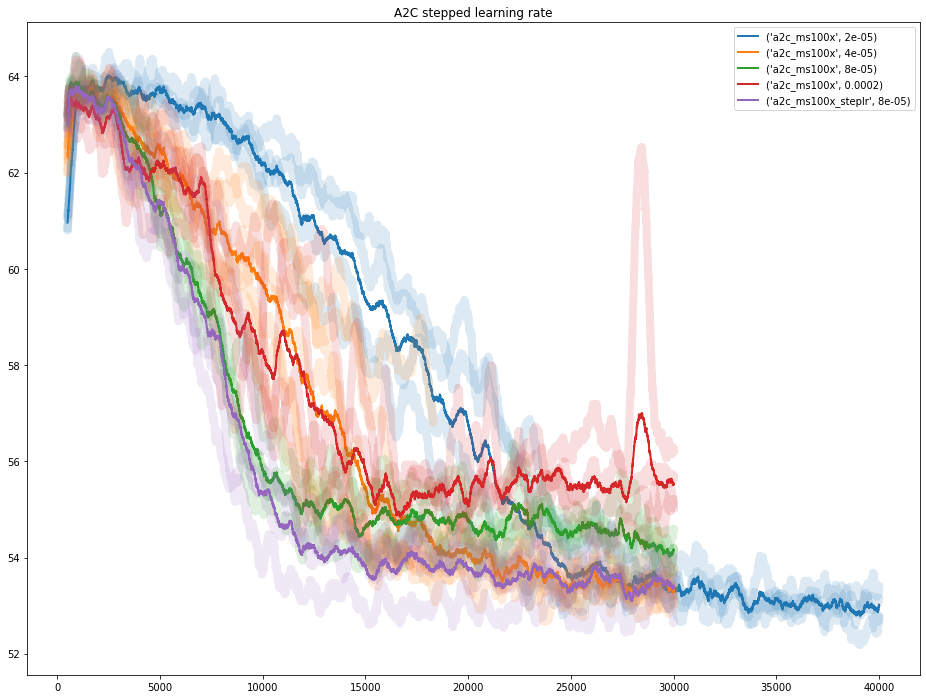

In [16]:
df = load_experiments(["a2c_ms100x_mediumrandoms_stepped", "a2c_ms100x_mediumrandoms"])
plt.figure(figsize=(16, 12))
plt.title("A2C stepped learning rate")
generate_variation_plot(df, ['agent_type', 'learning_rate'], 500)

In [17]:
def try_open(files):
    for f in files:
        try:
            return open(f)
        except FileNotFoundError:
            pass

def load_entropy_steps(path):
    path = Path(path)
    with try_open([path / "entropy_steps.txt", path / "episode_entropies.txt"]) as f:
        entropy_steps = [[float(w) for w in l.strip()[1:].split() if w] for l in f.read().split("]")[:-1]]
        return np.array(entropy_steps).transpose()
        
def generate_entropy_plot(entropy_steps):
    cmap = plt.get_cmap("rainbow")
    for i in range(entropy_steps.shape[0]):
        series=pd.Series(entropy_steps[i])
        rolling = series.rolling(window=1000)
        max_entropy=np.log(np.square(16-i))
        plt.plot(rolling.mean()/max_entropy, alpha=0.5, color=cmap(i/16), label=f"Step {i}")
    plt.legend()
    
def step_entropy_plot(entropy_steps, episode=-1, window=500):
    n = entropy_steps.shape[0]+1
    max_entropies = np.log(np.square(n - np.arange(n-1)))
    plt.plot(entropy_steps.transpose()[episode-window:episode].mean(axis=0) / max_entropies, label=f"Episode {episode} (mean of {window})")
    

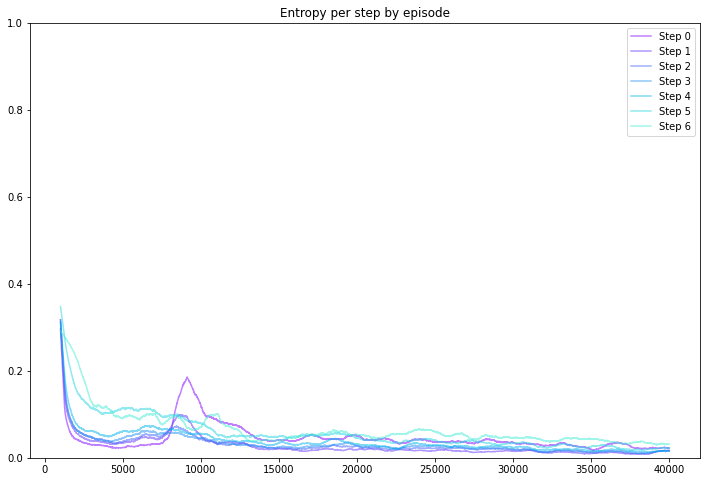

In [18]:
# warning: think about max_entropy normalization in the functions above before using these results
plt.figure(figsize=(12,8))
plt.title("Entropy per step by episode")
#entropies = load_entropy_steps("../runs/a2c_ms100x_mediumrandoms/lr4e-5_s1/")
entropies = load_entropy_steps("../runs/a2c_ms100x_smallrandoms/lr4e-5_s1/")
plt.ylim(0,1.0)
#plt.semilogy()
generate_entropy_plot(entropies)

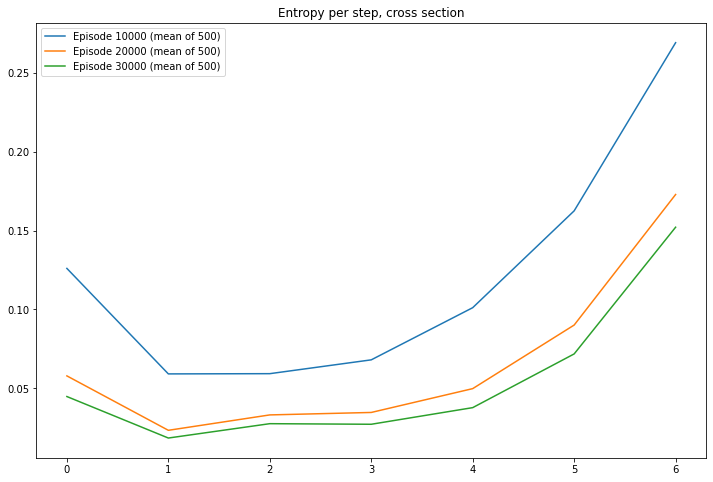

In [19]:
plt.figure(figsize=(12,8))
plt.title("Entropy per step, cross section")
step_entropy_plot(entropies, episode=10000)
step_entropy_plot(entropies, episode=20000)
step_entropy_plot(entropies, episode=30000)
#plt.semilogy()
plt.legend()

## DQN hyperparameters

In [20]:
df = load_experiments(["dqn_dense_ms_ec_eps0_mediumrandoms"])
df

0     \
path                                               seed agent_type           learning_rate gnn_depth hidden_size              
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       2         32           62.841865   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       2         64           60.356959   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       3         32           54.686776   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       3         64           58.385339   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       4         32           55.460938   
...                                                                                                                     ...   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e... 4    dqn_dense_ms_ec_eps0 0.00050       2         64           61.176668   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e... 4    dqn_dense_ms_ec_eps0 0.00050       3         32           58.853293   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e... 4    dqn_dense_ms_ec_eps0 0.00050       3         64           61.478632   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e... 4    dqn_dense_ms_ec_eps0 0.00050       4         32           55.929913   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e... 4    dqn_dense_ms_ec_eps0 0.00050       4         64           57.263823   

                                                                                                                       1     \
path                                               seed agent_type           learning_rate gnn_depth hidden_size              
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       2         32           65.490401   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       2         64           63.078010   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       3         32           58.461986   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       3         64           60.947965   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       4         32           59.356697   
...                                                                                                                     ...   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e... 4    dqn_dense_ms_ec_eps0 0.00050       2         64           71.078549   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e... 4    dqn_dense_ms_ec_eps0 0.00050       3         32           67.119416   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e... 4    dqn_dense_ms_ec_eps0 0.00050       3         64           66.584907   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e... 4    dqn_dense_ms_ec_eps0 0.00050       4         32           66.916919   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e... 4    dqn_dense_ms_ec_eps0 0.00050       4         64           67.691243   

                                                                                                                       2     \
path                                               seed agent_type           learning_rate gnn_depth hidden_size              
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       2         32           68.707125   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       2         64           66.283673   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       3         32           63.025775   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1    dqn_dense_ms_ec_eps0 0.00001       3         64           63.547658   
../runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr1e... 1 

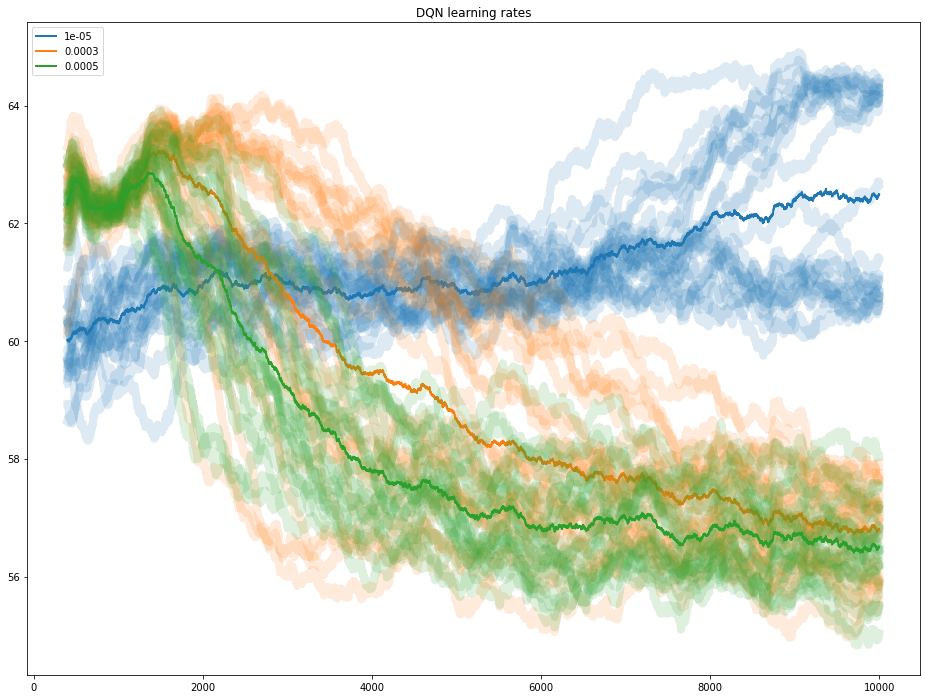

In [21]:
plt.figure(figsize=(16, 12))
plt.title("DQN learning rates")
generate_variation_plot(df, ['learning_rate'], 400)

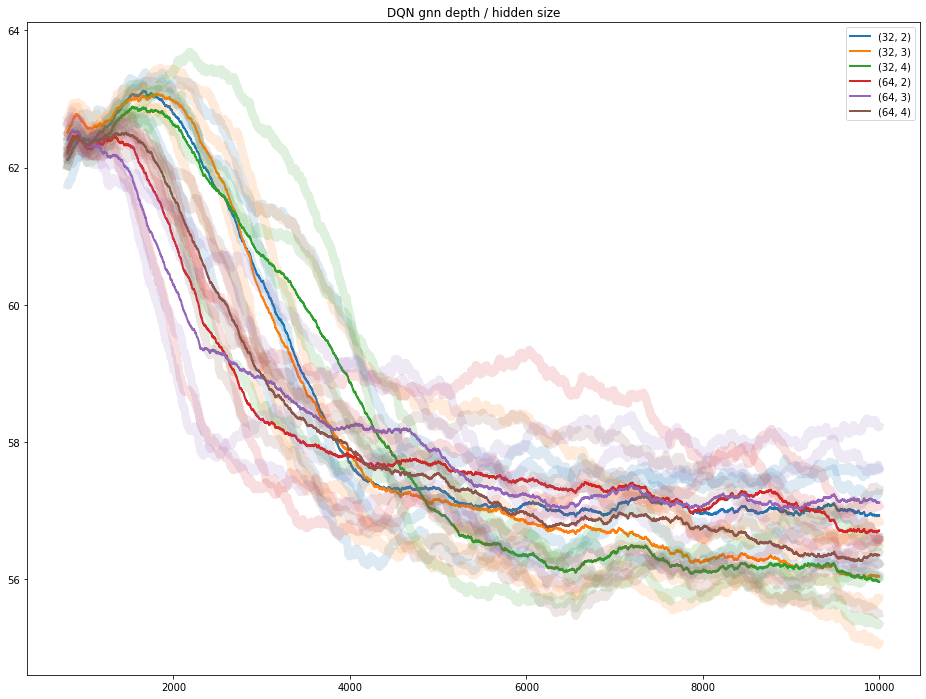

In [22]:
plt.figure(figsize=(16, 12))
plt.title("DQN gnn depth / hidden size")
generate_variation_plot(df.query('learning_rate == 5e-4'), ['hidden_size', 'gnn_depth'], 800)

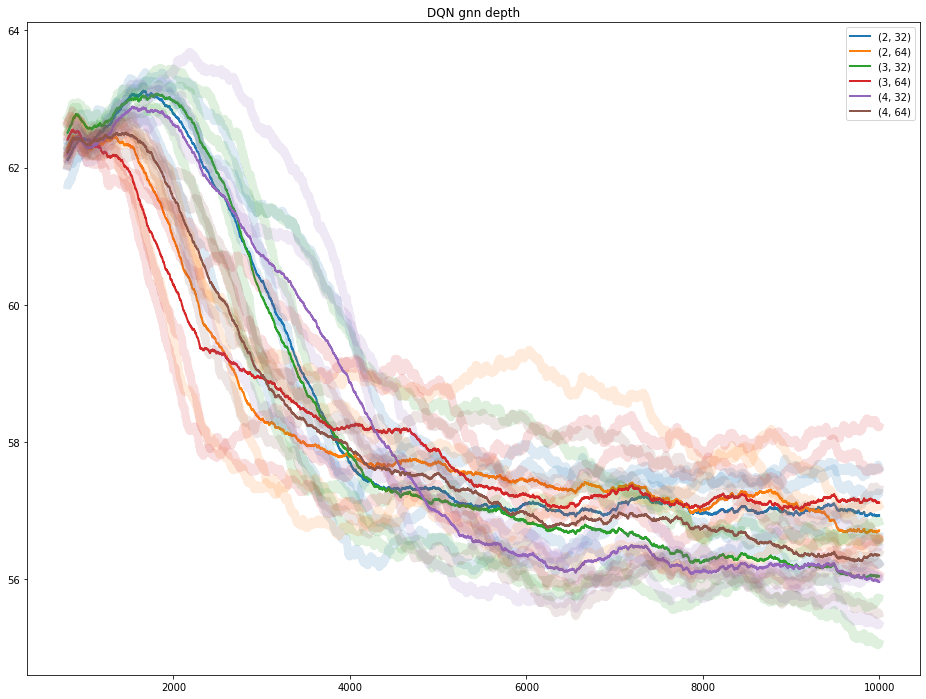

In [23]:
plt.figure(figsize=(16, 12))
plt.title("DQN gnn depth")
generate_variation_plot(df.query('learning_rate == 5e-4'), ['gnn_depth', 'hidden_size'], 800)

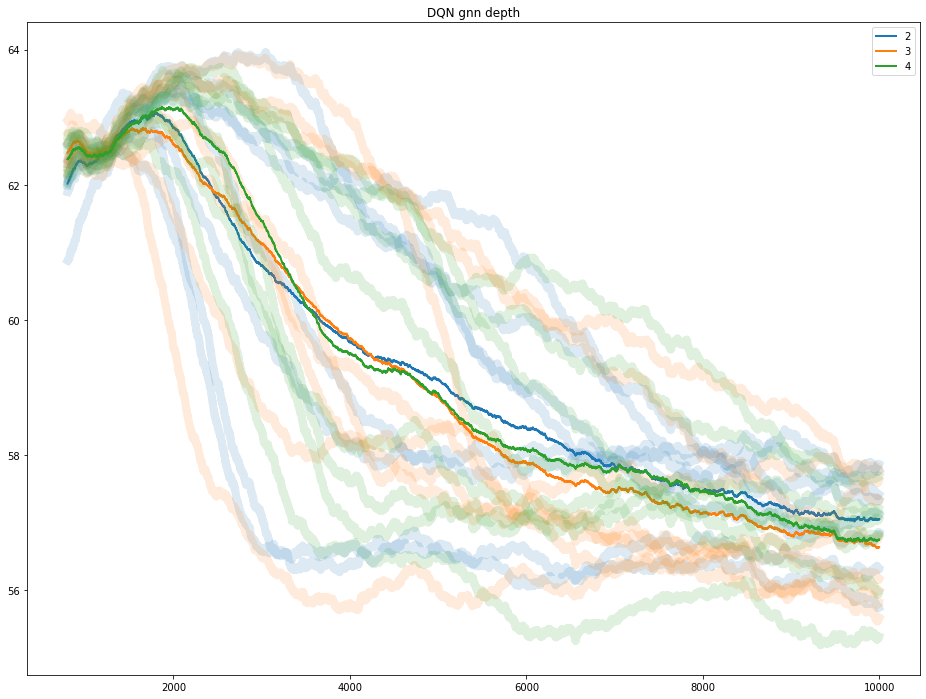

In [24]:
plt.figure(figsize=(16, 12))
plt.title("DQN gnn depth")
generate_variation_plot(df.query('learning_rate == 3e-4'), ['gnn_depth'], 800)

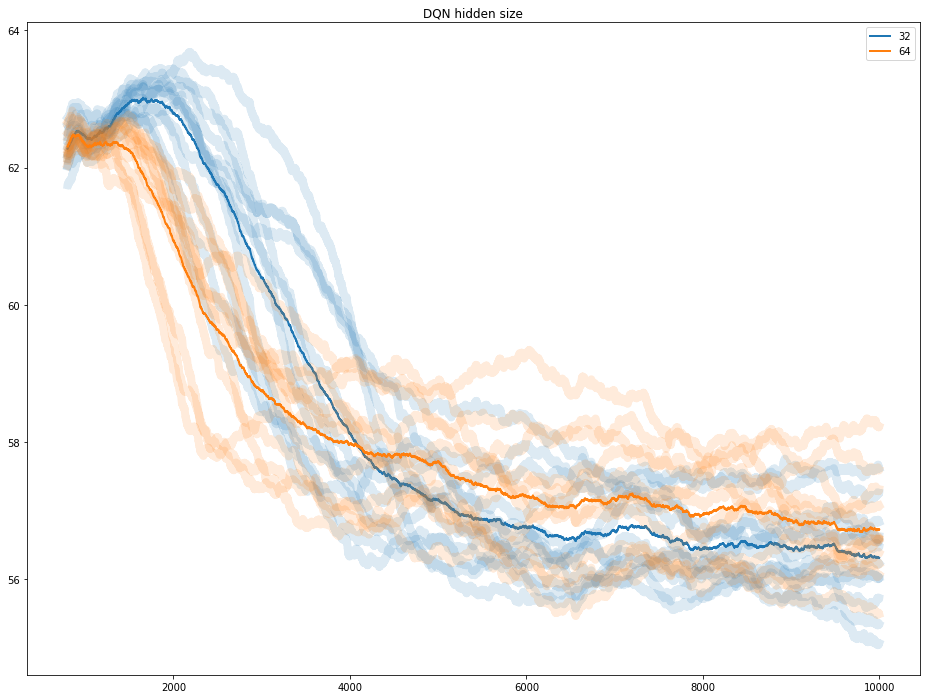

In [25]:
plt.figure(figsize=(16, 12))
plt.title("DQN hidden size")
generate_variation_plot(df.query('learning_rate == 5e-4'), ['hidden_size'], 800)

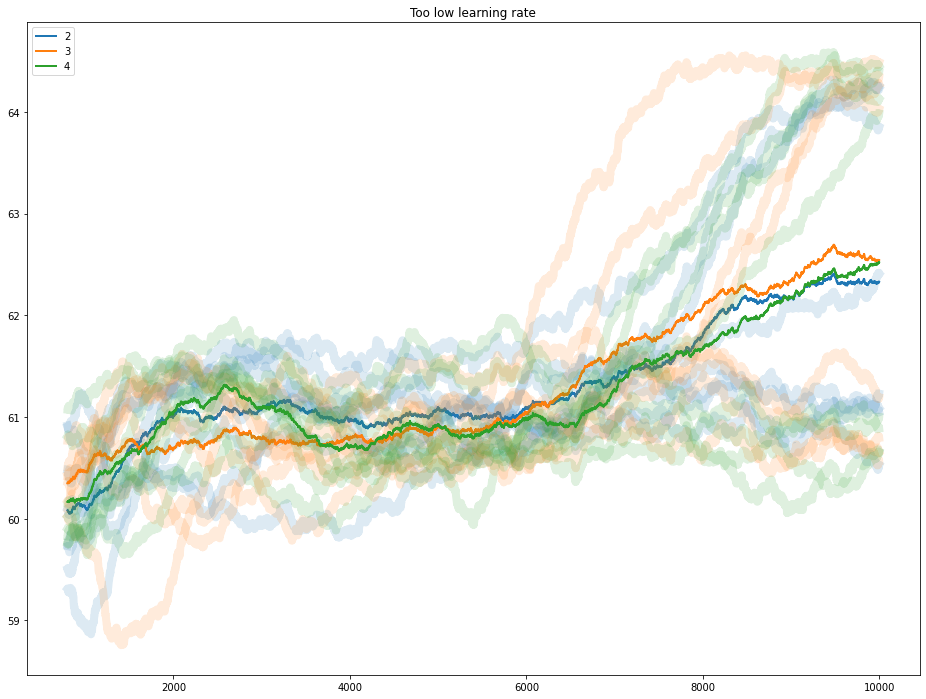

In [26]:
plt.figure(figsize=(16, 12))
plt.title("Too low learning rate")
generate_variation_plot(df.query('learning_rate == 1e-5'), ['gnn_depth'], 800)

### Epsilon vs no epsilon

In [27]:
df = load_experiments(["dqn_dense_ms_ec_mediumrandoms", "dqn_dense_ms_ec_eps0_mediumrandoms"])

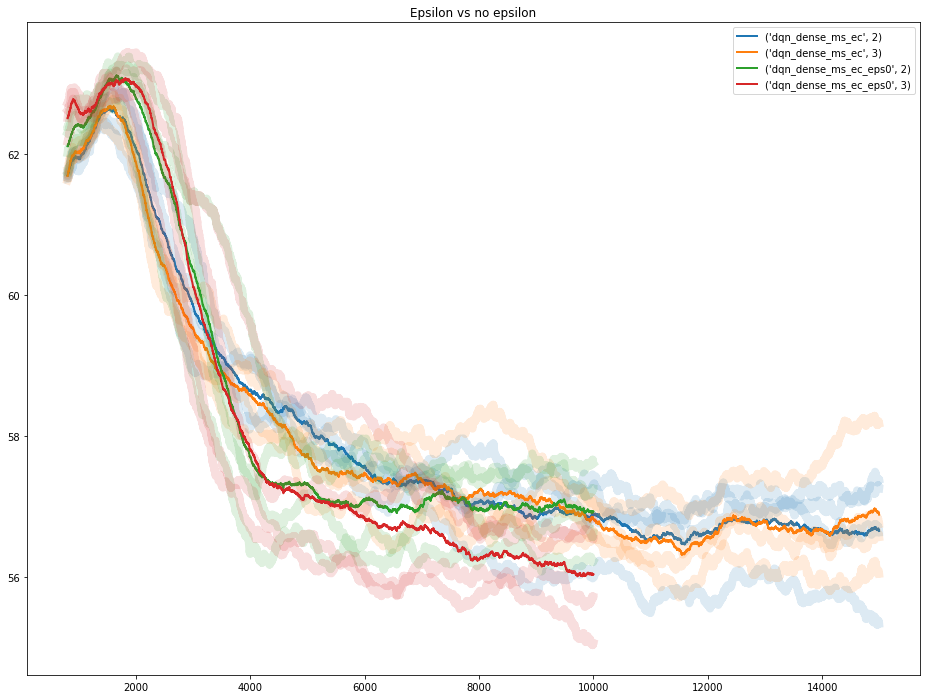

In [28]:
plt.figure(figsize=(16, 12))
plt.title("Epsilon vs no epsilon")
generate_variation_plot(df.query('learning_rate == 5e-4 & gnn_depth <= 3 & hidden_size == 32'), ['agent_type', 'gnn_depth'], 800)

### Norms

In [29]:
df = load_experiments(["dqn_dense_ec_eps0_norm_study"])

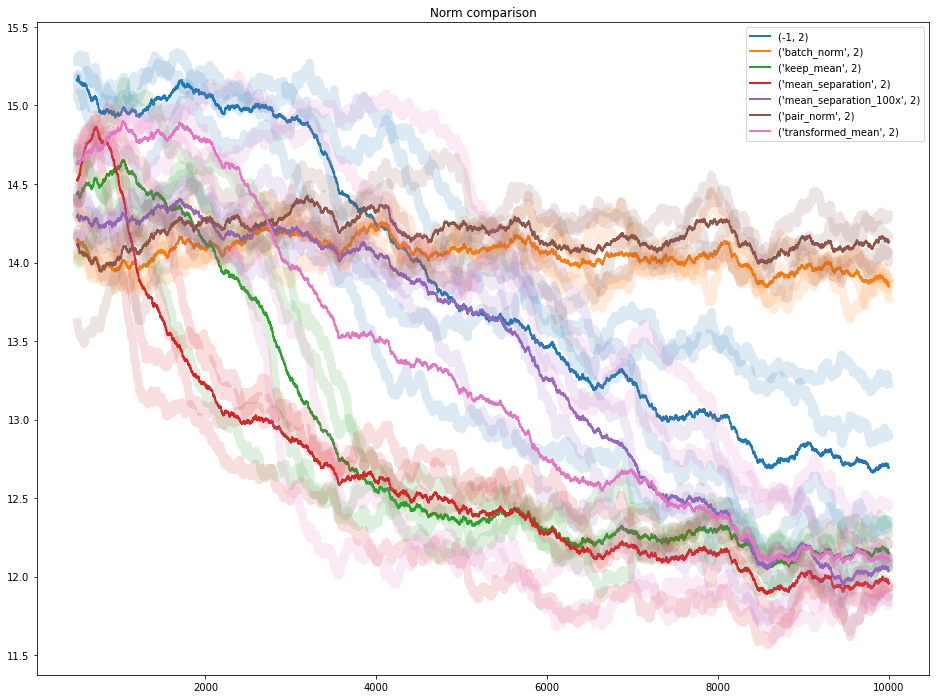

In [30]:
plt.figure(figsize=(16, 12))
plt.title("Norm comparison")
generate_variation_plot(df.query('gnn_depth == 2'), ['gnn_norm', 'gnn_depth'], 500)

## A2C / DQN vs REINFORCE

In [31]:
df = load_experiments(["a2c_ms100x_mediumrandoms", "reinforce_ms100x_mediumrandoms"])
df.query('agent_type == "reinforce_ms100x"')

0      \
path                                             seed agent_type       learning_rate gnn_depth mlp_depth              
../runs/reinforce_ms100x_mediumrandoms/lr2e-4_s1 1    reinforce_ms100x 0.00020       -1.0      -1.0       55.767970   
../runs/reinforce_ms100x_mediumrandoms/lr2e-4_s2 2    reinforce_ms100x 0.00020       -1.0      -1.0       58.414899   
../runs/reinforce_ms100x_mediumrandoms/lr2e-4_s3 3    reinforce_ms100x 0.00020       -1.0      -1.0       64.271917   
../runs/reinforce_ms100x_mediumrandoms/lr2e-4_s4 4    reinforce_ms100x 0.00020       -1.0      -1.0       59.165955   
../runs/reinforce_ms100x_mediumrandoms/lr4e-5_s1 1    reinforce_ms100x 0.00004       -1.0      -1.0       56.993766   
../runs/reinforce_ms100x_mediumrandoms/lr4e-5_s2 2    reinforce_ms100x 0.00004       -1.0      -1.0       58.105784   
../runs/reinforce_ms100x_mediumrandoms/lr4e-5_s3 3    reinforce_ms100x 0.00004       -1.0      -1.0       63.027261   
../runs/reinforce_ms100x_mediumrandoms/lr4e-5_s4 4    reinforce_ms100x 0.00004       -1.0      -1.0       57.915113   
../runs/reinforce_ms100x_mediumrandoms/lr8e-5_s1 1    reinforce_ms100x 0.00008       -1.0      -1.0       55.767970   
../runs/reinforce_ms100x_mediumrandoms/lr8e-5_s2 2    reinforce_ms100x 0.00008       -1.0      -1.0       55.390280   
../runs/reinforce_ms100x_mediumrandoms/lr8e-5_s3 3    reinforce_ms100x 0.00008       -1.0      -1.0       63.233129   
../runs/reinforce_ms100x_mediumrandoms/lr8e-5_s4 4    reinforce_ms100x 0.00008       -1.0      -1.0       57.574998   

                                                                                                              1      \
path                                             seed agent_type       learning_rate gnn_depth mlp_depth              
../runs/reinforce_ms100x_mediumrandoms/lr2e-4_s1 1    reinforce_ms100x 0.00020       -1.0      -1.0       60.074306   
../runs/reinforce_ms100x_mediumrandoms/lr2e-4_s2 2    reinforce_ms100x 0.00020       -1.0      -1.0       64.999871   
../runs/reinforce_ms100x_mediumrandoms/lr2e-4_s3 3    reinforce_ms100x 0.00020       -1.0      -1.0       60.341001   
../runs/reinforce_ms100x_mediumrandoms/lr2e-4_s4 4    reinforce_ms100x 0.00020       -1.0      -1.0       67.612565   
../runs/reinforce_ms100x_mediumrandoms/lr4e-5_s1 1    reinforce_ms100x 0.00004       -1.0      -1.0       60.074306   
../runs/reinforce_ms100x_mediumrandoms/lr4e-5_s2 2    reinforce_ms100x 0.00004       -1.0      -1.0       66.122163   
../runs/reinforce_ms100x_mediumrandoms/lr4e-5_s3 3    reinforce_ms100x 0.00004       -1.0      -1.0       60.341001   
../runs/reinforce_ms100x_mediumrandoms/lr4e-5_s4 4    reinforce_ms100x 0.00004       -1.0      -1.0       67.571549   
../runs/reinforce_ms100x_mediumrandoms/lr8e-5_s1 1    reinforce_ms100x 0.00008       -1.0      -1.0       60.074306   
../runs/reinforce_ms100x_mediumrandoms/lr8e-5_s2 2    reinforce_ms100x 0.00008       -1.0      -1.0       65.374411   
../runs/reinforce_ms100x_mediumrandoms/lr8e-5_s3 3    reinforce_ms100x 0.00008       -1.0      -1.0       61.567431   
../runs/reinforce_ms100x_mediumrandoms/lr8e-5_s4 4    reinforce_ms100x 0.00008       -1.0      -1.0       71.264181   

                                                                                                              2      \
path                                             seed agent_type       learning_rate gnn_depth mlp_depth              
../runs/reinforce_ms100x_mediumrandoms/lr2e-4_s1 1    reinforce_ms100x 0.00020       -1.0      -1.0       64.126662   
../runs/reinforce_ms100x_mediumrandoms/lr2e-4_s2 2    reinforce_ms100x 0.00020       -1.0      -1.0       60.869191   
../runs/reinforce_ms100x_mediumrandoms/lr2e-4_s3 3    reinforce_ms100x 0.00020       -1.0      -1.0       56.316754   
../runs/reinforce_ms100x_mediumrandoms/lr2e-4_s4 4    reinforce_ms100x 0.00020       -1.0      -1.0       55.389700   
../runs/reinforce_ms100x_mediumrandoms/lr4e-5_s1 1    reinforc

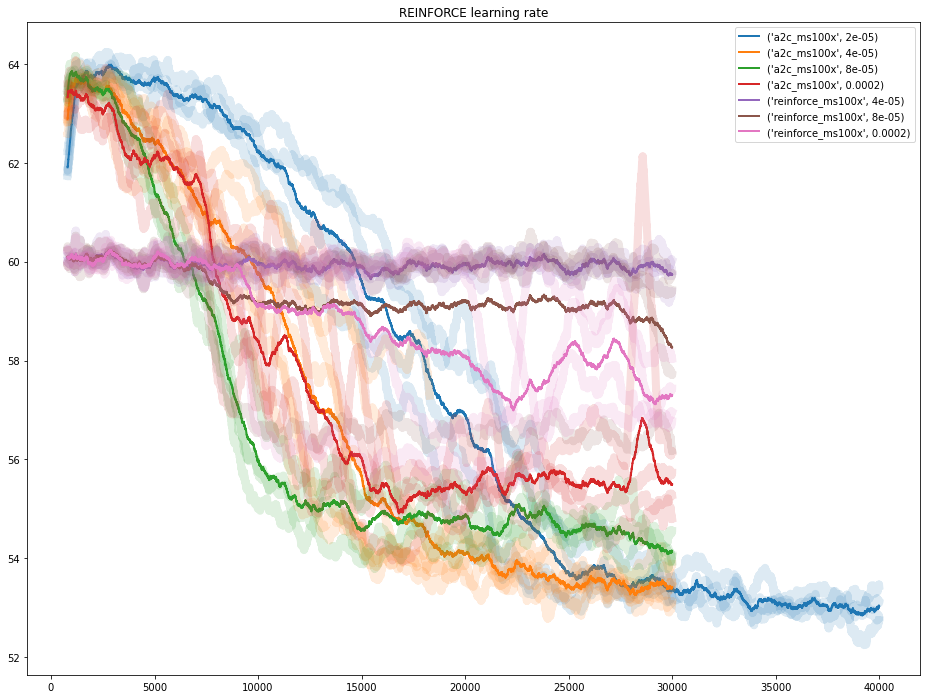

In [32]:
plt.figure(figsize=(16, 12))
plt.title("REINFORCE learning rate")
generate_variation_plot(df, ['agent_type', 'learning_rate'], 800)

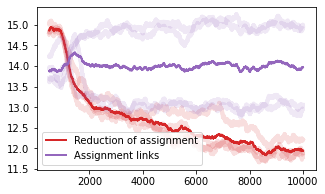

In [33]:
df = load_experiments(["dqn_linkedqap_eps_smallrandoms", "dqn_dense_ms_ec_eps0_smallrandoms"])
plt.figure(figsize=(5, 3))
generate_variation_plot(df, ['agent_type', 'learning_rate'], 500, labels={
    ('dqn_dense_ms_ec_eps0', 5e-4): 'Reduction of assignment',
    ('dqn_linkedqap_eps', 1e-5): 'Assignment links'
}, blurred_width=4)
plt.savefig(plots_root / "reduction_vs_linkedqap.pdf")

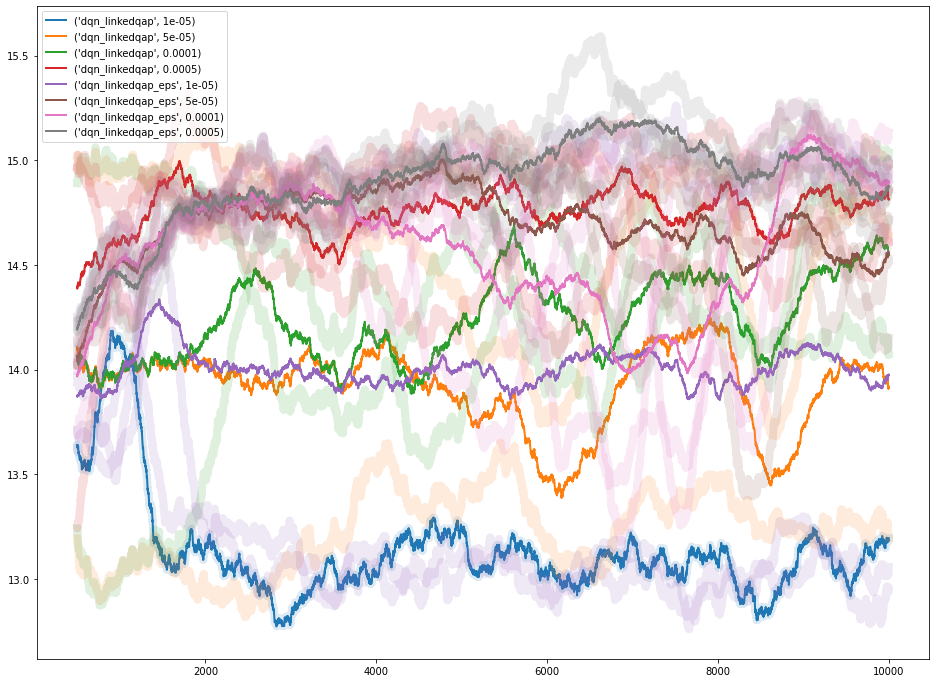

In [34]:
df = load_experiments(["dqn_linkedqap_eps_smallrandoms", "dqn_linkedqap_smallrandoms"])#, "dqn_dense_ms_ec_eps0_smallrandoms"])
plt.figure(figsize=(16, 12))
generate_variation_plot(df.query('gnn_depth<=2 & hidden_size<=32'), ['agent_type', 'learning_rate'], 500)

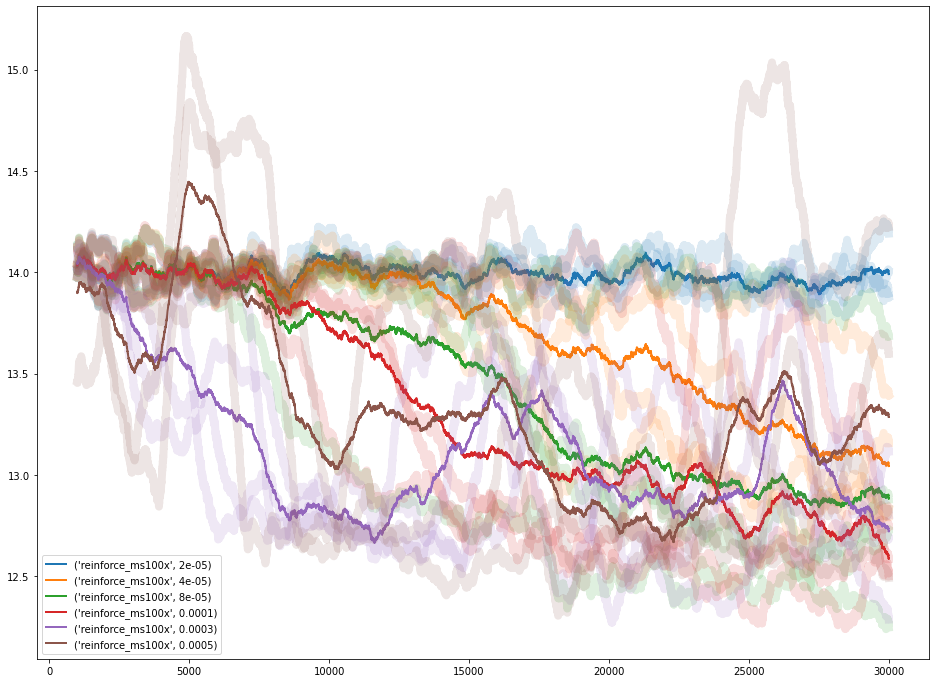

In [35]:
df = load_experiments(["reinforce_ms100x_smallrandoms"])
plt.figure(figsize=(16, 12))
generate_variation_plot(df, ['agent_type', 'learning_rate'], 1000)

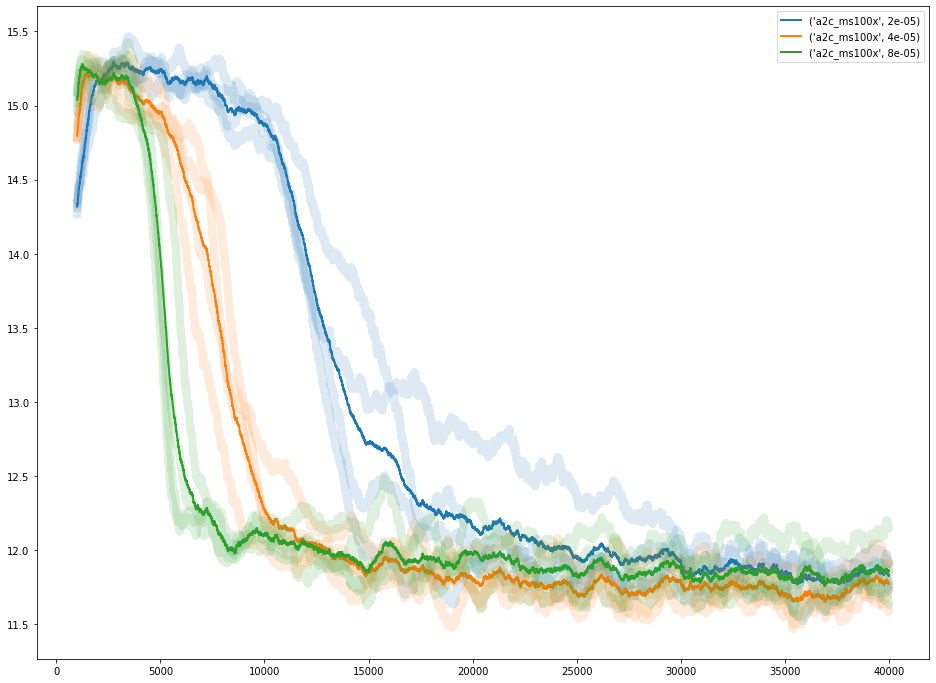

In [36]:
df = load_experiments(["a2c_ms100x_smallrandoms"])
plt.figure(figsize=(16, 12))
generate_variation_plot(df, ['agent_type', 'learning_rate'], 1000)

## Reinforce learning rates

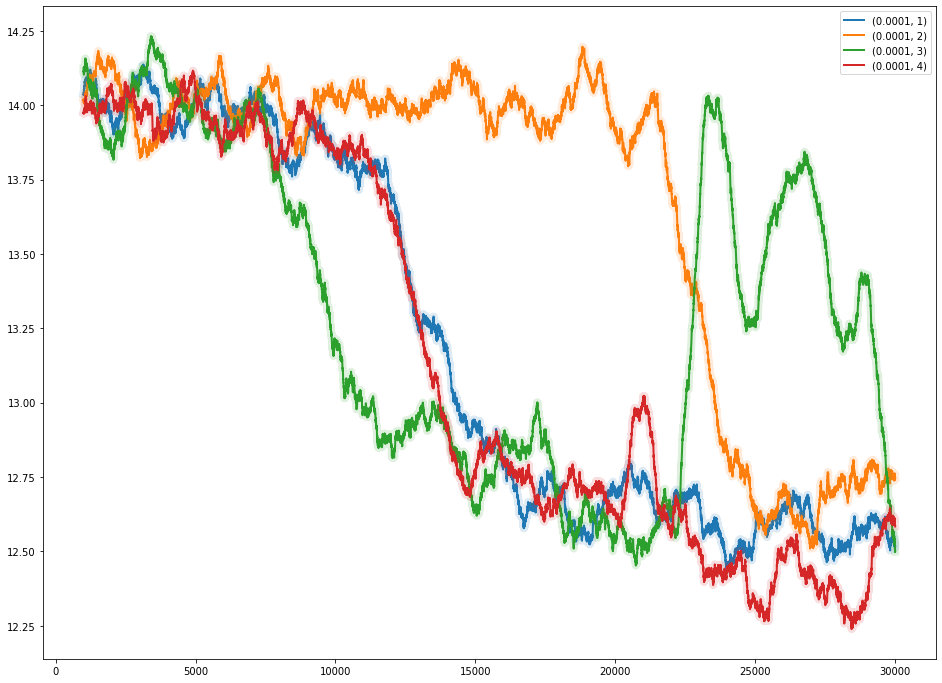

In [37]:
df = load_experiments(["reinforce_ms100x_smallrandoms"])
plt.figure(figsize=(16, 12))
generate_variation_plot(df.query("learning_rate == 0.0001"), ['learning_rate', 'seed'], 1000)
#generate_variation_plot(df, ['learning_rate'], 1000)

# MCQ

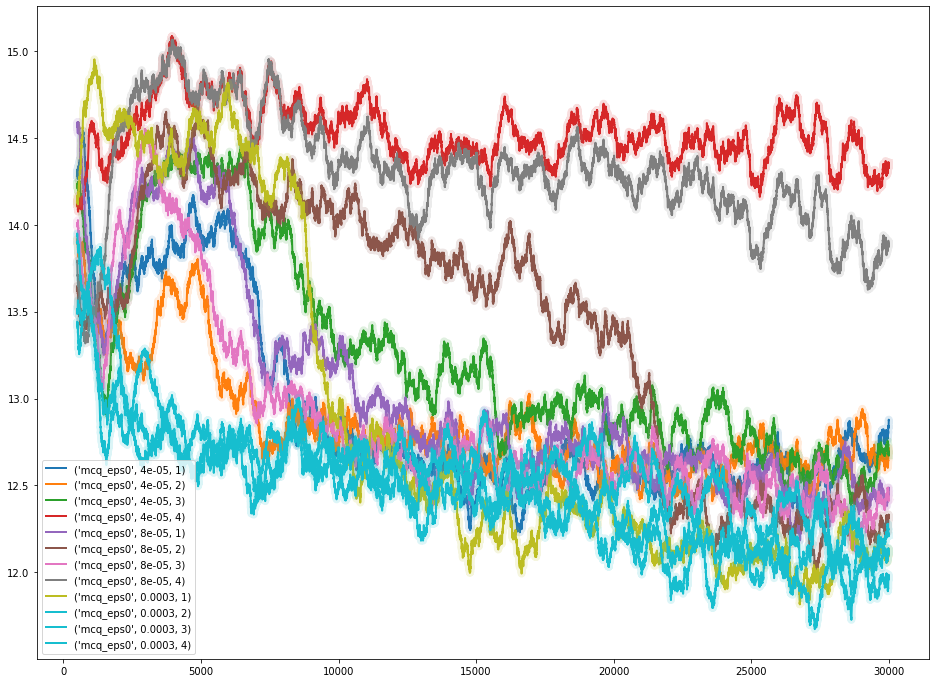

In [38]:
plt.figure(figsize=(16, 12))
df = load_experiments(["mcq_eps0_smallrandoms"], quantity="value")
generate_variation_plot(df.query("agent_type == 'mcq_eps0'"), ["agent_type", "learning_rate", 'seed'], 500)
#df = load_experiments(["reinforce_ms100x_smallrandoms"])
#generate_variation_plot(df.query("learning_rate==0.0001 & seed==1"), ["agent_type"], 300)
#plt.ylim(0,4.0)

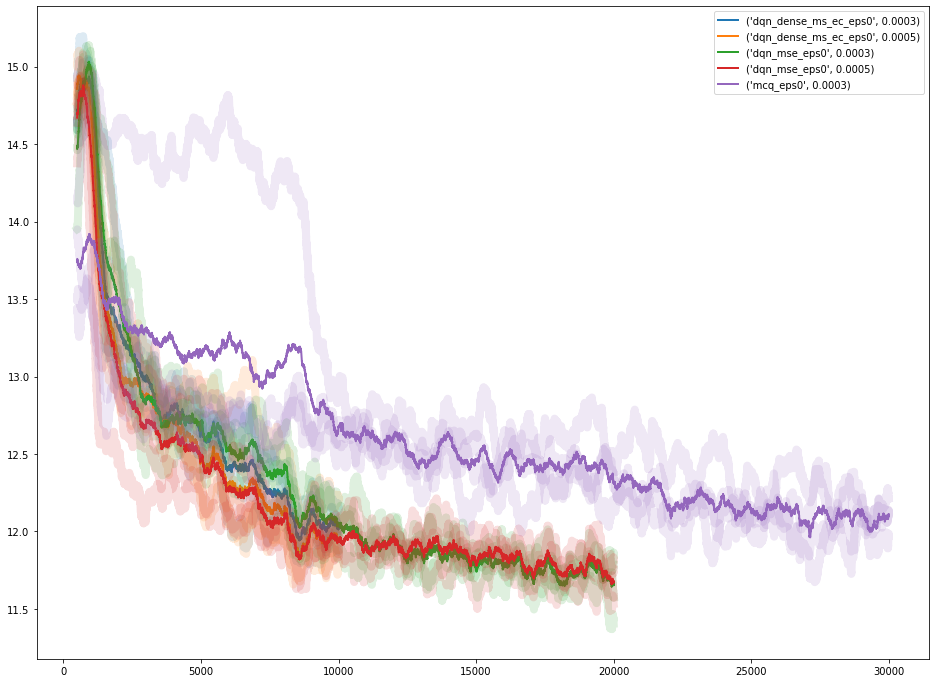

In [39]:
plt.figure(figsize=(16, 12))
df = load_experiments(["mcq_eps0_smallrandoms", "dqn_mse_eps0_smallrandoms", "dqn_dense_ms_ec_eps0_smallrandoms"], quantity="value")
generate_variation_plot(df.query("(agent_type == 'mcq_eps0' & learning_rate == 0.0003) | (agent_type != 'mcq_eps0' & learning_rate >= 3e-4)"), ["agent_type", "learning_rate"], 500)
#df = load_experiments(["reinforce_ms100x_smallrandoms"])
#generate_variation_plot(df.query("learning_rate==0.0001 & seed==1"), ["agent_type"], 300)
#plt.ylim(0,4.0)

# Reinforce Norm

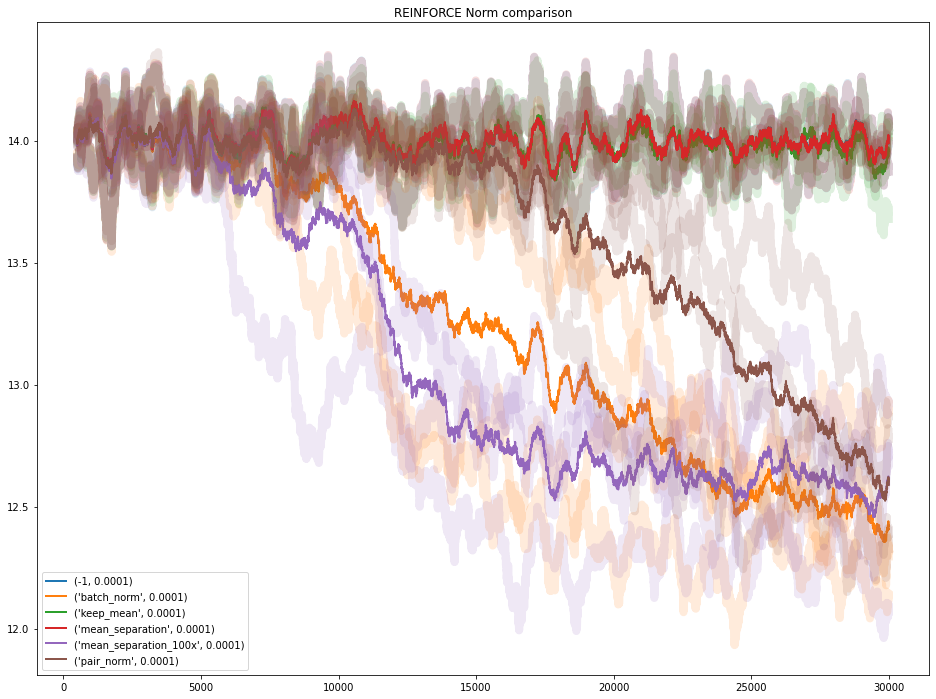

In [77]:
df = load_experiments(["reinforce_norm_study"])
plt.figure(figsize=(16, 12))
plt.title("REINFORCE Norm comparison")
generate_variation_plot(df, ['gnn_norm', 'learning_rate'], 500)

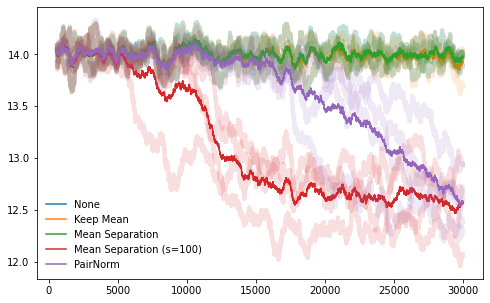

In [93]:
df = load_experiments(["reinforce_norm_study"]).query("gnn_norm in [-1, 'keep_mean', 'mean_separation', 'mean_separation_100x', 'pair_norm']")
plt.figure(figsize=(8, 5))
generate_variation_plot(df, ['gnn_norm'], 600, labels={
    -1: "None",
    'keep_mean': 'Keep Mean',
    'mean_separation': 'Mean Separation',
    'mean_separation_100x': 'Mean Separation (s=100)',
    'pair_norm': 'PairNorm',
}, blurred_width=4, mean_width=1.5)
plt.legend(loc="lower left", frameon=False)
plt.savefig(plots_root / "reinforce_norms.pdf")

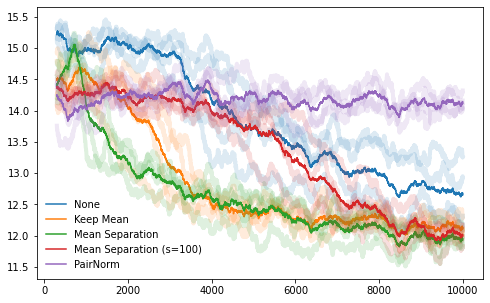

In [94]:
df = load_experiments(["dqn_dense_ec_eps0_norm_study"]).query("gnn_depth == 2").query("gnn_norm in [-1, 'keep_mean', 'mean_separation', 'mean_separation_100x', 'pair_norm']")
plt.figure(figsize=(8, 5))
generate_variation_plot(df, ['gnn_norm'], 300, labels={
    -1: "None",
    'keep_mean': 'Keep Mean',
    'mean_separation': 'Mean Separation',
    'mean_separation_100x': 'Mean Separation (s=100)',
    'pair_norm': 'PairNorm',
}, blurred_width=4, mean_width=1.5)
plt.legend(loc="lower left", frameon=False)
plt.savefig(plots_root / "dqn_norms.pdf")